## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [0]:
import pandas as pd
import numpy as np
import matplotlib as plt

adult = pd.read_csv('https://raw.githubusercontent.com/LambdaSchool/DS-Unit-1-Sprint-1-Dealing-With-Data/master/module3-databackedassertions/persons.csv')

In [0]:


#adult.exercise_time.describe()
age = pd.cut(adult['age'],31)
weight = pd.cut(adult.weight,73)
exercise = pd.cut(adult.exercise_time,30)
#exercise.head()
pd.crosstab(adult['age'], age)

TypeError: ignored

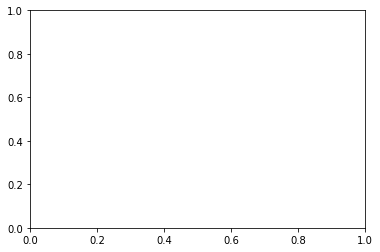

In [63]:

#plt.pyplot.bar(exercise,adult.exercise_time)

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?
2.  What are the relationships between the variables?
3.  Which relationships are "real", and which spurious?


Unnamed: 0       0
age              0
weight           0
exercise_time    0
dtype: int64

## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)